In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import zscore

In [284]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Load datasets
integrate4 = pd.read_csv('integrate4.csv')
tass5 = pd.read_csv('tass5.csv')
diag3 = pd.read_csv('diag3.csv')
intheset = pd.read_csv('intheset.csv')
car36 = pd.read_csv('car36.csv')
all_close_treat = pd.read_csv('all_close_treat.csv')

# Filter and process integrate4 data
df = integrate4[['id', 'mydate', 'crisis_treat24', 'crisis_treat24_90', 'fund_closedxcrisis', 'div_corr', 'corr_eps']]
df = df.sort_values(by=['id', 'mydate']).drop_duplicates(subset=['id', 'mydate'])

# Handle div_corr > 0.985
df.loc[df['div_corr'] > 0.985, 'div_corr'] = np.nan

# Calculate mindate
df['mindate'] = df.groupby('id')['mydate'].transform('min')

# Merge with tass5
df = df.merge(tass5, on=['id', 'mydate'], how='left')

# Merge with diag3 to get pre_treat and other variables
df = df.merge(diag3, on='companyid', how='left')

# Create TREATED variable
df['TREATED'] = np.where((df['mydate'] > 593) & (df['mydate'] <= 617) & (df['pre_treat'] == 1), 1, 0)

# Merge with intheset
df = df.merge(intheset, on=['id', 'mydate'], how='left')

# Calculate additional variables
df['fundcounter_i'] = 1
df['missing_aum_firm'] = df['aum'].isna().astype(int)

# Aggregate firm-level data
firm_level_agg = df.groupby(['companyid', 'mydate']).agg({
    'aum': 'sum',
    'fundcounter_i': 'sum',
    'missing_aum_firm': 'max'
}).reset_index().rename(columns={
    'aum': 'aum_firm',
    'fundcounter_i': 'fundcounter_j'
})

firm_level_agg['log_firmscope'] = np.log(firm_level_agg['fundcounter_j'])

# Merge the firm-level data back to the original dataframe
df = df.merge(firm_level_agg, on=['companyid', 'mydate'], how='left')

df['age'] = df['mydate'] - df['mindate'] + 1
df['log_age'] = np.log(df['age'])

# Create deciles for aum and age
df['sz_dec'] = pd.qcut(df['aum'], 10, labels=False)
df['age_dec'] = pd.qcut(df['age'], 10, labels=False)

# Create size decile dummies
sz_q_dummies = pd.get_dummies(df['sz_dec'], prefix='sz_q')
df = pd.concat([df, sz_q_dummies], axis=1)

# Create post variable (assuming crisis ends at mydate 593)
df['post'] = np.where(df['mydate'] > 593, 1, 0)

# Handle missing aum
df['missing_aum'] = df['aum'].isna().astype(int)

# Calculate standardized variables and IR
df['stdv'] = df['stdv'].clip(df['stdv'].quantile(0.01), df['stdv'].quantile(0.99))
df['ir'] = df['excess_ret'] / df['stdv']
df['ir'] = df['ir'].clip(df['ir'].quantile(0.01), df['ir'].quantile(0.99))

df['excess_ret'] = df['excess_ret'].clip(df['excess_ret'].quantile(0.01), df['excess_ret'].quantile(0.99))

# Calculate scope quartiles
df['firmscope'] = np.exp(df['log_firmscope'])
df['scope_q1'] = np.where(df['firmscope'] <= df['firmscope'].quantile(0.25), 1, 0)
df['scope_q2'] = np.where(df['firmscope'].between(df['firmscope'].quantile(0.25), df['firmscope'].quantile(0.50)), 1, 0)
df['scope_q3'] = np.where(df['firmscope'].between(df['firmscope'].quantile(0.50), df['firmscope'].quantile(0.75)), 1, 0)
df['scope_q4'] = np.where(df['firmscope'] > df['firmscope'].quantile(0.75), 1, 0)

# Ensure mydate is a string and pad it to the correct length
df['mydate'] = df['mydate'].astype(str).str.pad(width=8, fillchar='0')

df['date'] = pd.to_datetime(df['date'])
# Create year variable
df['year'] = pd.to_datetime(df['date'], format='%Y%m%d').dt.year
# Ensure year_dum variables are correctly created
year_dummies = pd.get_dummies(df['year'], prefix='year_dum')
df = pd.concat([df, year_dummies], axis=1)

df['int1c'] = np.where(df['div_corr'].notna(), df['div_corr'] * df['TREATED'], 0)
df['ever_treated'] = df.groupby('id')['TREATED'].transform('max').astype(bool)
df['first30'] = np.where(df['ever_treated'] & df['mydate'].astype(int).between(594, 623), 1, 0)
df['second30'] = np.where(df['ever_treated'] & df['mydate'].astype(int).between(624, 653), 1, 0)
df['sz_dec'] = pd.qcut(df['aum_firm'], 10, labels=False)
firmsz_q_dummies = pd.get_dummies(df['sz_dec'], prefix='firmsz_q')
df = pd.concat([df, firmsz_q_dummies], axis=1)
# Create dummies for firm age deciles
df['firmage_q'] = pd.qcut(df['age'], 10, labels=False)
firmage_q_dummies = pd.get_dummies(df['firmage_q'], prefix='firmage_q')
df = pd.concat([df, firmage_q_dummies], axis=1)
df['age_dec'] = pd.qcut(df['age'], 10, labels=False)
age_q_dummies = pd.get_dummies(df['age_dec'], prefix='age_q')
df = pd.concat([df, age_q_dummies], axis=1)

tass7 = df.copy()

# Create firm-level data for fund-level analysis
df_firm_level = df[df['intheset'] == 1]
df_firm_level = df_firm_level[df_firm_level['firmscope'] < 50]
df_firm_level = df_firm_level.groupby(['companyid', 'mydate']).agg({
    'excess_ret': 'mean',
    'ret': 'mean',
    'post': 'mean',
    'aum': 'mean',
    'fundcounter_j': 'max',
    'TREATED': 'max',
    'age': 'max',
    **{col: 'mean' for col in year_dummies.columns},
    **{col: 'mean' for col in sz_q_dummies.columns}
}).reset_index()
df_firm_level['log_firmscope'] = np.log(df_firm_level['fundcounter_j'])
df_firm_level['log_firmage'] = np.log(df_firm_level['age'] + 1)
df_firm_level['age_dec'] = pd.qcut(df_firm_level['age'], 10, labels=False)
df_firm_level = pd.get_dummies(df_firm_level, columns=['age_dec'], prefix='firmage_q')
df_firm_level['stdv_firm'] = df_firm_level.groupby(['companyid', 'TREATED'])['excess_ret'].transform('std')
df_firm_level['firm_ir'] = df_firm_level['excess_ret'] / df_firm_level['stdv_firm']
df_firm_level = df_firm_level.rename(columns={'fundcounter_j': 'firm_scope', 'age': 'firm_age'})

tass8 = df_firm_level.copy()
# Fund-level analysis: Merge datasets
columns_to_merge_from_tass7 = ['companyid', 'mydate', 'TREATED','missing_aum', 'int1c', 'ever_treated', 'first30', 'second30', 'id', 'div_corr', 'fund_closedxcrisis','firmscope', 'intheset', 'scope_q1', 'scope_q2', 'scope_q3', 'scope_q4', 'aum', 'log_age',
                               'ir']
columns_to_merge_from_tass7.extend(firmsz_q_dummies.columns)  # Add the firmsize dummies
columns_to_merge_from_tass7.extend(firmage_q_dummies.columns) # Add the firmage dummies
columns_to_merge_from_tass7.extend(age_q_dummies.columns) # Add the firmage dummies

df_fund_level = tass8.merge(
    tass7[columns_to_merge_from_tass7], 
    on=['companyid', 'mydate'], 
    how='left'
)
# Ensure 'id' is present in car36
car36['id'] = car36['id'].astype(str)
df_fund_level['id'] = df_fund_level['id'].astype(str)

# Convert mydate in car36 to string for merging
car36['mydate'] = car36['mydate'].astype(str).str.pad(width=8, fillchar='0')
all_close_treat['mydate'] = all_close_treat['mydate'].astype(str).str.pad(width=8, fillchar='0')

df_fund_level = df_fund_level.merge(car36[['id', 'mydate']], on=['id', 'mydate'], how='left')
df_fund_level = df_fund_level.merge(all_close_treat[['companyid', 'mydate', 'all_close_treat']], on=['companyid', 'mydate'], how='left')
df_fund_level = df_fund_level.loc[:, ~df_fund_level.columns.duplicated()]

# Check if TREATED variable exists after merging steps
df_fund_level['TREATED'] = df_fund_level['TREATED_x']
df_fund_level['ALL_TREAT'] = df_fund_level['all_close_treat'] - df_fund_level['TREATED']
print(tass7.columns)

C:\Users\hendrikv\AppData\Local\Temp\ipykernel_15096\3644091940.py:7: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  integrate4 = pd.read_csv('integrate4.csv')


Index(['id', 'mydate', 'crisis_treat24', 'crisis_treat24_90',
       'fund_closedxcrisis', 'div_corr', 'corr_eps', 'mindate', 'date', 'ret',
       ...
       'age_q_0', 'age_q_1', 'age_q_2', 'age_q_3', 'age_q_4', 'age_q_5',
       'age_q_6', 'age_q_7', 'age_q_8', 'age_q_9'],
      dtype='object', length=128)


REG1 part 2

In [286]:
df_fund_level['ALL_TREAT'] = df_fund_level['all_close_treat'] - df_fund_level['TREATED']
df_fund_level['ALL_TREAT'] = df_fund_level['ALL_TREAT'].clip(lower=0)

df_fund_level['time_treat'] = df_fund_level['mydate'].astype(int) - 594
df_fund_level['int2'] = df_fund_level['TREATED'] * df_fund_level['time_treat']
df_fund_level['int3'] = df_fund_level['ALL_TREAT'] * df_fund_level['time_treat']
df_fund_level['int3'] = df_fund_level['int3'].fillna(0)

df_fund_level['max_treated'] = df_fund_level.groupby('id')['TREATED'].transform('max')
df_fund_level['max_treated'] = np.where(df_fund_level['mydate'].astype(int) < 594, 0, df_fund_level['max_treated'])

df_fund_level['first24'] = np.where(df_fund_level['mydate'].astype(int).between(594, 617), 1, 0)
df_fund_level['next36'] = np.where(df_fund_level['mydate'].astype(int) > 617, 1, 0)

df_fund_level['Tx24'] = df_fund_level['max_treated'] * df_fund_level['first24']
df_fund_level['Txn36'] = df_fund_level['max_treated'] * df_fund_level['next36']

df_fund_level['max_int1c'] = df_fund_level.groupby('id')['int1c'].transform('max')
df_fund_level['max_int1c'] = np.where(df_fund_level['mydate'].astype(int) < 594, 0, df_fund_level['max_int1c'])

df_fund_level['max_int2'] = df_fund_level.groupby('id')['int2'].transform('max')
df_fund_level['max_int2'] = np.where(df_fund_level['mydate'].astype(int) < 594, 0, df_fund_level['max_int2'])

df_fund_level['Tx24xrelated'] = df_fund_level['Tx24'] * df_fund_level['max_int1c']
df_fund_level['Txn36xrelated'] = df_fund_level['Txn36'] * df_fund_level['max_int1c']

df_fund_level['triple_int'] = np.where(df_fund_level['div_corr'].notna(), df_fund_level['TREATED'] * df_fund_level['time_treat'] * df_fund_level['div_corr'], 0)
df_fund_level['int1c_max'] = np.where(df_fund_level['div_corr'].notna(), df_fund_level['max_treated'] * df_fund_level['div_corr'], 0)
df_fund_level['int2_max'] = df_fund_level['max_treated'] * df_fund_level['time_treat']
df_fund_level['triple_int_max'] = np.where(df_fund_level['div_corr'].notna(), df_fund_level['max_treated'] * df_fund_level['time_treat'] * df_fund_level['div_corr'], 0)

df_fund_level['max_firmscope'] = df_fund_level.groupby('companyid')['firmscope'].transform('max')
median_max_firmscope = df_fund_level.loc[(df_fund_level['max_treated'] == 1) & (df_fund_level['intheset'] == 1) & (df_fund_level['firmscope'] < 50), 'max_firmscope'].median()

df_fund_level.to_csv('tass12.csv', index=False)

# Summary statistics
summary_stats = df_fund_level[(df_fund_level['intheset'] == 1) & (df_fund_level['mydate'].astype(int) <= 617) & (df_fund_level['firmscope'] < 50)].describe()
summary_stats.to_csv('summary_stats.csv')

# # Function to add missing dummy variables
# def add_missing_dummies(df, prefix, n):
#     for i in range(n):
#         col_name = f"{prefix}{i}"
#         if col_name not in df.columns:
#             df[col_name] = 0
#     return df

# # Ensure all dummy variables are present
# df_fund_level = add_missing_dummies(df_fund_level, 'sz_q', 10)
# df_fund_level = add_missing_dummies(df_fund_level, 'scope_q', 5)
# df_fund_level = add_missing_dummies(df_fund_level, 'age_q', 10)
# df_fund_level = add_missing_dummies(df_fund_level, 'firmsz_q', 10)
# df_fund_level = add_missing_dummies(df_fund_level, 'firmage_q', 10)
# df_fund_level = add_missing_dummies(df_fund_level, 'year_dum_', 19)  # 1994 to 2012

# Basic IR Results
# Convert categorical variables to strings for patsy formula
# df_fund_level['sz_q'] = df_fund_level['sz_q'].astype(str)
# df_fund_level['scope_q'] = df_fund_level['scope_q'].astype(str)
# df_fund_level['age_q'] = df_fund_level['age_q'].astype(str)
# df_fund_level['firmsz_q'] = df_fund_level['firmsz_q'].astype(str)
# df_fund_level['firmage_q'] = df_fund_level['firmage_q'].astype(str)

# Basic IR Results

# Filter the dataframe for the regression
regression_df = df_fund_level[(df_fund_level['intheset'] == 1) & (df_fund_level['mydate'].astype(int) <= 617) & (df_fund_level['firmscope'] < 50)]

# for i in range(10):
#     regression_df[f'sz_q{i}'] = regression_df[f'sz_q_{i}']
#     regression_df[f'age_q{i}'] = int(regression_df[f'age_q_{i}']==0) 
#     regression_df[f'firmsz_q{i}'] = int(regression_df[f'firmsz_q_{i}.0'] == 0)
#     regression_df[f'firmage_q{i}'] = int(regression_df[f'firmage_q_{i}_y'] == 0)

for i in range(10):
    regression_df[f'sz_q{i}'] = regression_df[f'sz_q_{i}']
    regression_df[f'age_q{i}'] = (regression_df[f'age_q_{i}']) 
    regression_df[f'firmsz_q{i}'] = (regression_df[f'firmsz_q_{i}.0'])
    regression_df[f'firmage_q{i}'] = (regression_df[f'firmage_q_{i}_y'])

# Minimal regression model
# 1. Drop unnecessary dummy variables 
# Assuming you have dummy variables like sz_q0, sz_q1, ..., sz_q9, keep only sz_q1 to sz_q9
# regression_df = regression_df.drop(columns=['sz_q0'])  # Similarly drop first dummy for other categorical variables

# 2. Handling Missing Values
# Impute or drop missing values in the relevant columns
regression_df.dropna(subset=['ir', 'TREATED'] + [col for col in regression_df.columns if col.startswith(('sz_q', 'scope_q', 'age_q', 'firmsz_q', 'firmage_q', 'year_dum_'))], inplace=True)

# 3. Filtering for clustering
# Ensure groups have at least two observations
id_counts = regression_df['id'].value_counts()
regression_df = regression_df[regression_df['id'].isin(id_counts[id_counts > 1].index)]

# Double-check and convert 'id' to numeric if needed
regression_df['id'] = pd.to_numeric(regression_df['id']) 

# 4. Reset the index after filtering
regression_df = regression_df.reset_index(drop=True)
regression_df.to_csv('regression_df.csv')

C:\Users\hendrikv\AppData\Local\Temp\ipykernel_15096\4164532247.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regression_df[f'sz_q{i}'] = regression_df[f'sz_q_{i}']
C:\Users\hendrikv\AppData\Local\Temp\ipykernel_15096\4164532247.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regression_df[f'age_q{i}'] = (regression_df[f'age_q_{i}'])
C:\Users\hendrikv\AppData\Local\Temp\ipykernel_15096\4164532247.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

In [195]:
regression_df


,companyid,mydate,excess_ret,ret,post,aum_x,firm_scope,TREATED_x,firm_age,year_dum_1994,...,year_dum_9,year_dum_10,year_dum_11,year_dum_12,year_dum_13,year_dum_14,year_dum_15,year_dum_16,year_dum_17,year_dum_18
0,29.0,00000526,196.374435,-0.016699,0.0,1.478643e+07,1.0,0,1,0.0,...,0,0,0,0,0,0,0,0,0,0
1,29.0,00000527,196.449057,-0.005199,0.0,3.372292e+07,1.0,0,2,0.0,...,0,0,0,0,0,0,0,0,0,0
2,29.0,00000528,194.830884,-0.017199,0.0,2.153770e+07,2.0,0,3,0.0,...,0,0,0,0,0,0,0,0,0,0
3,29.0,00000528,194.830884,-0.017199,0.0,2.153770e+07,2.0,0,3,0.0,...,0,0,0,0,0,0,0,0,0,0
4,29.0,00000529,194.847303,-0.002550,0.0,2.147236e+07,2.0,0,4,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94306,96683.0,00000613,44.188605,0.014399,1.0,1.269940e+09,1.0,0,67,0.0,...,0,0,0,0,0,0,0,0,0,0
94307,96683.0,00000614,44.206181,0.001499,1.0,1.309984e+09,1.0,0,68,0.0,...,0,0,0,0,0,0,0,0,0,0
94308,96683.0,00000615,44.220488,0.017199,1.0,1.338020e+09,1.0,0,69,0.0,...,0,0,0,0,0,0,0,0,0,0
94309,96683.0,00000616,44.185000,-0.004399,1.0,1.336691e+09,1.0,0,70,0.0,...,0,0,0,0,0,0,0,0,0,0


In [287]:
# List of columns to keep
columns_to_keep = ['ir', 'TREATED', 'intheset'] + \
                  [f'sz_q{i}' for i in range(10)] + \
                  [f'scope_q{i}' for i in range(1, 5)] + \
                  [f'age_q{i}' for i in range(10)] + \
                  [f'firmsz_q{i}' for i in range(10)] + \
                  [f'firmage_q{i}' for i in range(10)] + \
                  [f'year_dum_{i}' for i in range(1994, 2012)]

# Select the specified columns from the dataframe
selected_data = regression_df[columns_to_keep]

# Save the new dataset to a CSV file
selected_data.to_csv('pure_regression.csv', index=False)

PermissionError: [Errno 13] Permission denied: 'pure_regression.csv'

In [ ]:
 + ' + ' +
                ' + '.join([f'age_q{i}' for i in range(10)])

In [235]:
selected_data

,ir,TREATED,sz_q0,sz_q1,sz_q2,sz_q3,sz_q4,sz_q5,sz_q6,sz_q7,...,year_dum_2002,year_dum_2003,year_dum_2004,year_dum_2005,year_dum_2006,year_dum_2007,year_dum_2008,year_dum_2009,year_dum_2010,year_dum_2011
0,2.312391,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.313270,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.313564,0,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.269495,0,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.313653,0,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94306,2.226710,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
94307,2.227596,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
94308,2.228317,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
94309,2.226529,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [289]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a dataframe with the independent variables
X = regression_df[['TREATED'] + [f'sz_q{i}' for i in range(10)] + [f'scope_q{i}' for i in range(1, 5)] 
                   + [f'year_dum_{i}' for i in range(1994, 2008)]+[f'year_dum_{i}' for i in range(2009, 2012)]]

# Add a constant
X = sm.add_constant(X)

# Calculate VIF for each feature
vif = pd.DataFrame()
vif['Variable'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


         Variable           VIF
0           const  0.000000e+00
1         TREATED  1.070131e+00
2           sz_q0           inf
3           sz_q1           inf
4           sz_q2  2.246681e+07
5           sz_q3           inf
6           sz_q4           inf
7           sz_q5           inf
8           sz_q6           inf
9           sz_q7  3.295096e+08
10          sz_q8           inf
11          sz_q9           inf
12       scope_q1           inf
13       scope_q2  3.015677e+00
14       scope_q3           inf
15       scope_q4           inf
16  year_dum_1994           inf
17  year_dum_1995           inf
18  year_dum_1996           inf
19  year_dum_1997           inf
20  year_dum_1998           inf
21  year_dum_1999           inf
22  year_dum_2000           inf
23  year_dum_2001           inf
24  year_dum_2002           inf
25  year_dum_2003           inf
26  year_dum_2004           inf
27  year_dum_2005           inf
28  year_dum_2006           inf
29  year_dum_2007           inf
30  year

In [290]:
# Basic IR Results
model = smf.ols('ir ~ TREATED +' + ' + '  .join([f'sz_q{i}' for i in range(10)])+ ' + ' +
                # ' + '.join([f'age_q{i}' for i in range(10)])+ ' + ' +
                ' + '.join([f'scope_q{i}' for i in range(1, 5)]) + ' + ' +
                # ' + '.join([f'firmsz_q{i}' for i in range(10)]) + ' + ' +
                # ' + '.join([f'firmage_q{i}' for i in range(10)]) + ' + ' +

                ' + '.join([f'year_dum_{i}' for i in range(1994, 2008)])+ ' + ' +
                ' + '.join([f'year_dum_{i}' for i in range(2009, 2012)]),data=regression_df).fit(cov_type='cluster', cov_kwds={'groups': regression_df['id']})

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     ir   R-squared:                       0.194
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     51.09
Date:                Thu, 20 Jun 2024   Prob (F-statistic):          1.23e-187
Time:                        22:38:24   Log-Likelihood:            -1.7329e+05
No. Observations:               94311   AIC:                         3.466e+05
Df Residuals:                   94281   BIC:                         3.469e+05
Df Model:                          29                                         
Covariance Type:              cluster                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.4435      0.043     10.235

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 32, but rank is 30
  warnings.warn('covariance of constraints does not have full '


0


KeyboardInterrupt: 

Exception ignored in: 'statsmodels.nonparametric._smoothers_lowess.calculate_weights'
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py", line 2172, in _sum_dispatcher
    def _sum_dispatcher(a, axis=None, dtype=None, out=None, keepdims=None,
    
KeyboardInterrupt: 


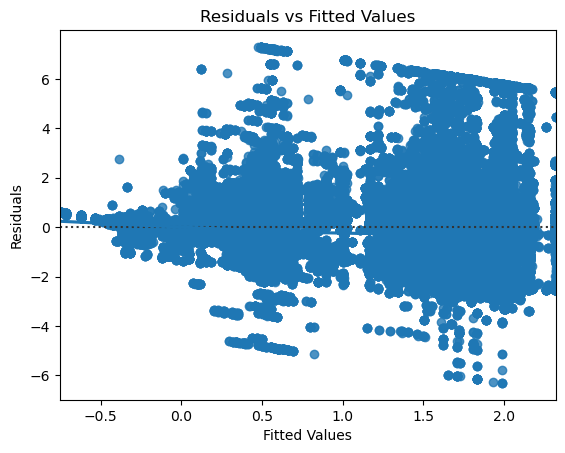

In [252]:
print(regression_df.duplicated().sum())
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting residuals vs fitted values
sns.residplot(x=model.fittedvalues, y=model.resid, lowess=True)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()


In [293]:


# Additional regressions as needed
# Regression model with absorb(id)
model_absorb = smf.ols('ir ~ TREATED + ' +
                       ' + '.join([f'sz_q{i}' for i in range(1, 10)]) + ' + ' +
                       ' + '.join([f'scope_q{i}' for i in range(1, 5)]) + ' + ' +
                       # ' + '.join([f'age_q{i}' for i in range(1, 10)]) + ' + ' +
                       # ' + '.join([f'firmsz_q{i}' for i in range(10)]) + ' + ' +
                       # ' + '.join([f'firmage_q{i}' for i in range(10)]) + ' + ' +
                       ' + '.join([f'year_dum_{i}' for i in range(1994, 2012)]),
                       data=regression_df[(regression_df['intheset'] == 1) & (regression_df['mydate'].astype(int) <= 617) & (regression_df['firmscope'] < 50)]).fit(cov_type='cluster', cov_kwds={'groups': regression_df['id']})

print(model_absorb.summary())

# Save model results
with open('model_absorb_results.txt', 'w') as f:
    f.write(model_absorb.summary().as_text())

# Additional analyses and summary statistics
regression_df['median_rel_int'] = 0
regression_df['median_rel_int'] = regression_df['int1c'].where(regression_df['int1c'] >= regression_df['int1c'].median(), 0)
regression_df['median_rel_int'] = regression_df['median_rel_int'].where(regression_df['int1c'] < regression_df['int1c'].median(), 1)

regression_df['intheset2'] = regression_df['intheset'].where(regression_df['median_rel_int'] == 1, 0)
regression_df['intheset3'] = regression_df['intheset'].where(regression_df['median_rel_int'] == 0, 0)

model_rel_int = smf.ols('ir ~ max_treated + time_treat + ' +
                        ' + '.join([f'sz_q{i}' for i in range(1, 10)]) + ' + ' +
                        ' + '.join([f'scope_q{i}' for i in range(1, 5)]) + ' + ' +
                        # ' + '.join([f'age_q{i}' for i in range(1, 10)]) + ' + ' +
                        # ' + '.join([f'firmsz_q{i}' for i in range(10)]) + ' + ' +
                        # ' + '.join([f'firmage_q{i}' for i in range(10)]) + ' + ' +
                        ' + '.join([f'year_dum_{i}' for i in range(1994, 2012)]),
                        data=regression_df[(regression_df['intheset2'] == 1) & (regression_df['firmscope'] < 50)]).fit(cov_type='cluster', cov_kwds={'groups': regression_df['id']})

print(model_rel_int.summary())
with open('model_rel_int_results.txt', 'w') as f:
    f.write(model_rel_int.summary().as_text())
##########################################################################################################################################################################
# Create grouped object for clustering BEFORE filtering
grouped = regression_df.groupby('id')

# Regressions for additional analysis
# Model for "related" firms with firmscope < 50
filtered_related = grouped.filter(lambda x: len(x) >= 2 and (x['intheset2'] == 1).any() and (x['firmscope'] < 50).all())  # Filter within groups
model_rel_int = smf.ols('ir ~ max_treated + time_treat + ' +
                        ' + '.join([f'sz_q{i}' for i in range(1, 10)]) + ' + ' +
                        ' + '.join([f'scope_q{i}' for i in range(1, 5)]) + ' + ' +
                        # ' + '.join([f'age_q{i}' for i in range(1, 10)]) + ' + ' +
                        # ' + '.join([f'firmsz_q{i}' for i in range(1, 10)]) + ' + ' +
                        # ' + '.join([f'firmage_q{i}' for i in range(1, 10)]) + ' + ' +
                        ' + '.join([f'year_dum_{i}' for i in range(1994, 2012)]),
                        data=filtered_related).fit(cov_type='cluster', cov_kwds={'groups': filtered_related['id']})
print(model_rel_int.summary())
with open('model_rel_int_results.txt', 'w') as f:
    f.write(model_rel_int.summary().as_text())

# Subsample regressions
median_max_firmscope = regression_df[(regression_df['max_treated'] == 1) & (regression_df['intheset'] == 1) & (regression_df['firmscope'] < 50)]['max_firmscope'].median()

# Model: firm_ir ~ max_treated + int1c_max + int2_max + triple_int_max + controls (firmscope < median)
filtered_low_scope = grouped.filter(lambda x: len(x) >= 2 and (x['max_firmscope'] < median_max_firmscope).all())
model_subsample_review_1 = smf.ols('firm_ir ~ max_treated + int1c_max + int2_max + triple_int_max + ' +
                                   ' + '.join([f'sz_q{i}' for i in range(1, 10)]) + ' + ' +
                                   ' + '.join([f'scope_q{i}' for i in range(1, 5)]) + ' + ' +
                                   # ' + '.join([f'age_q{i}' for i in range(1, 10)]) + ' + ' +
                                   # ' + '.join([f'firmsz_q{i}' for i in range(1, 10)]) + ' + ' +
                                   # ' + '.join([f'firmage_q{i}' for i in range(1, 10)]) + ' + ' +
                                   ' + '.join([f'year_dum_{i}' for i in range(1994, 2012)]),
                                   data=filtered_low_scope).fit(cov_type='cluster', cov_kwds={'groups': filtered_low_scope['id']})
print(model_subsample_review_1.summary())
with open('model_subsample_review_1_results.txt', 'w') as f:
    f.write(model_subsample_review_1.summary().as_text())

# Model: firm_ir ~ max_treated + int1c_max + int2_max + triple_int_max + controls (firmscope >= median)
filtered_high_scope = grouped.filter(lambda x: len(x) >= 2 and (x['max_firmscope'] >= median_max_firmscope).all())
model_subsample_review_2 = smf.ols('firm_ir ~ max_treated + int1c_max + int2_max + triple_int_max + ' +
                                   ' + '.join([f'sz_q{i}' for i in range(1, 10)]) + ' + ' +
                                   ' + '.join([f'scope_q{i}' for i in range(1, 5)]) + ' + ' +
                                   # ' + '.join([f'age_q{i}' for i in range(1, 10)]) + ' + ' +
                                   # ' + '.join([f'firmsz_q{i}' for i in range(1, 10)]) + ' + ' +
                                   # ' + '.join([f'firmage_q{i}' for i in range(1, 10)]) + ' + ' +
                                   ' + '.join([f'year_dum_{i}' for i in range(1994, 2012)]),
                                   data=filtered_high_scope).fit(cov_type='cluster', cov_kwds={'groups': filtered_high_scope['id']})
print(model_subsample_review_2.summary())
with open('model_subsample_review_2_results.txt', 'w') as f:
    f.write(model_subsample_review_2.summary().as_text())
# Save model results

########################################################################################################################################

# Additional preparations for the regressions and final steps of reg1.do
# Subsample regressions as called for by reviewer
model_subsample_review_1 = smf.ols('firm_ir ~ max_treated + int1c_max + int2_max + triple_int_max + ' +
                                   ' + '.join([f'sz_q{i}' for i in range(1, 10)]) + ' + ' +
                                   ' + '.join([f'scope_q{i}' for i in range(1, 5)]) + ' + ' +
                                   # ' + '.join([f'age_q{i}' for i in range(1, 10)]) + ' + ' +
                                   # ' + '.join([f'firmsz_q{i}' for i in range(10)]) + ' + ' +
                                   # ' + '.join([f'firmage_q{i}' for i in range(10)]) + ' + ' +
                                   ' + '.join([f'year_dum_{i}' for i in range(1994, 2012)]),
                                   data=regression_df[regression_df['max_firmscope'] < median_max_firmscope]).fit(cov_type='cluster', cov_kwds={'groups': regression_df['id']})
print(model_subsample_review_1.summary())
with open('model_subsample_review_1_results.txt', 'w') as f:
    f.write(model_subsample_review_1.summary().as_text())

model_subsample_review_2 = smf.ols('firm_ir ~ max_treated + int1c_max + int2_max + triple_int_max + ' +
                                   ' + '.join([f'sz_q{i}' for i in range(1, 10)]) + ' + ' +
                                   ' + '.join([f'scope_q{i}' for i in range(1, 5)]) + ' + ' +
                                   # ' + '.join([f'age_q{i}' for i in range(1, 10)]) + ' + ' +
                                   # ' + '.join([f'firmsz_q{i}' for i in range(10)]) + ' + ' +
                                   # ' + '.join([f'firmage_q{i}' for i in range(10)]) + ' + ' +
                                   ' + '.join([f'year_dum_{i}' for i in range(1994, 2012)]),
                                   data=regression_df[regression_df['max_firmscope'] >= median_max_firmscope]).fit(cov_type='cluster', cov_kwds={'groups': regression_df['id']})
print(model_subsample_review_2.summary())
with open('model_subsample_review_2_results.txt', 'w') as f:
    f.write(model_subsample_review_2.summary().as_text())


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 32, but rank is 30
  warnings.warn('covariance of constraints does not have full '


                            OLS Regression Results                            
Dep. Variable:                     ir   R-squared:                       0.194
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     51.09
Date:                Thu, 20 Jun 2024   Prob (F-statistic):          1.23e-187
Time:                        22:40:53   Log-Likelihood:            -1.7329e+05
No. Observations:               94311   AIC:                         3.466e+05
Df Residuals:                   94281   BIC:                         3.469e+05
Df Model:                          29                                         
Covariance Type:              cluster                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.6714      0.075      9.003

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 33, but rank is 31
  warnings.warn('covariance of constraints does not have full '


                            OLS Regression Results                            
Dep. Variable:                     ir   R-squared:                       0.194
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     51.25
Date:                Thu, 20 Jun 2024   Prob (F-statistic):          5.01e-192
Time:                        22:40:53   Log-Likelihood:            -1.7329e+05
No. Observations:               94311   AIC:                         3.466e+05
Df Residuals:                   94280   BIC:                         3.469e+05
Df Model:                          30                                         
Covariance Type:              cluster                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.9287      0.093     10.034

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 33, but rank is 31
  warnings.warn('covariance of constraints does not have full '


                            OLS Regression Results                            
Dep. Variable:                     ir   R-squared:                       0.194
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     51.25
Date:                Thu, 20 Jun 2024   Prob (F-statistic):          5.01e-192
Time:                        22:40:54   Log-Likelihood:            -1.7329e+05
No. Observations:               94311   AIC:                         3.466e+05
Df Residuals:                   94280   BIC:                         3.469e+05
Df Model:                          30                                         
Covariance Type:              cluster                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.9287      0.093     10.034

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1732: RuntimeWarning: invalid value encountered in subtract
  return np.sum(weights * (model.endog - mean)**2)


ValueError: r_matrix performs f_test for using dimensions that are asymptotically non-normal